In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline
import talib
import datetime as dt

In [2]:
### Import Data and Arrange Time
kozaa = pd.read_csv("KOZAA.csv",sep = ";", header= None, index_col=0, parse_dates = True)
kozaa.rename(columns={1: 'Open', 2: 'High', 3: 'Low', 4: 'Close', 5:'Volume'}, inplace=True)
kozaa.index.names = ['Date']
kozaa = kozaa.loc['2009-01-01':'2018-12-31']
kozaa = kozaa.fillna(method='ffill')

In [3]:
### Calculate Daily Returns
kozaa["Returns"] = kozaa["Close"].pct_change()
kozaa["ForwardReturns"] = kozaa["Returns"].shift(-1) #forward returns
kozaa["ReturnSign"] = np.nan
kozaa.loc[kozaa["ForwardReturns"]>0,"ReturnSign"]=1
kozaa.loc[kozaa["ForwardReturns"]<0,"ReturnSign"]=-1
kozaa.loc[kozaa["ForwardReturns"]==0,"ReturnSign"]=1
kozaa=kozaa.loc[np.logical_not(np.isnan(kozaa["ForwardReturns"]))] #remove last line NA

In [4]:
### Calculate Technical Analysis Indicators
kozaa["MA10"]=talib.SMA(kozaa["Close"], timeperiod=10)
kozaa["MA10change"] = kozaa["MA10"].pct_change()
kozaa["MA21"]=talib.SMA(kozaa["Close"], timeperiod=21)
kozaa["MA21change"] = kozaa["MA21"].pct_change()
kozaa["UpperBbans"],kozaa["MiddleBbans"],kozaa["LowerBbans"]=talib.BBANDS(kozaa["Close"], timeperiod = 8, nbdevup=2, nbdevdn=2)
kozaa["BBupper"] = kozaa["Close"]/kozaa["UpperBbans"]-1
kozaa["BBlower"] = kozaa["Close"]/kozaa["LowerBbans"]-1
kozaa["%K"], kozaa["%D"] = talib.STOCHF(kozaa["High"],kozaa["Low"], kozaa["Close"], fastk_period=14, fastd_period=3, fastd_matype=0)
kozaa["%Kchange"]=kozaa["%K"]-kozaa["%K"].shift(1)
kozaa["%Dchange"]=kozaa["%D"]-kozaa["%D"].shift(1)
kozaa["RSI"] = talib.RSI(kozaa["Close"], timeperiod=14)
kozaa["ClMA"] = kozaa["Close"]/kozaa["MA21"]-1
kozaa["VolumeChange"] = kozaa["Volume"].pct_change()
kozaa["MA-SLchange"] = kozaa["MA10"]/kozaa["MA21"].shift(1)-1

In [5]:
### Remove first 21 NA lines because of MA_21 change
kozaa=kozaa.iloc[21:,]

In [6]:
X = kozaa.iloc[:,[5,9,11,15,16,17,18,19,20,21,22,23,24]] #features  
y = kozaa.iloc[:,7] #labels

In [7]:
### Seperate testing and training data
Xdic = {}
ydic = {}
for i in range(2009,2019):
    Xdic["KOZAA{0}".format(i)]=X[X.index.year == i]
    ydic["KOZAA{0}".format(i)]=y[y.index.year == i]


Xtraindic = {}
Xtestdic = {}
ytraindic = {}
ytestdic = {}
for i in range(2009,2016):
    Xtraindic["X_train{0}".format(i)] = pd.concat([Xdic["KOZAA{0}".format(i)],Xdic["KOZAA{0}".format(i+1)],Xdic["KOZAA{0}".format(i+2)]]).values
    Xtestdic["X_test{0}".format(i)] = Xdic["KOZAA{0}".format(i+3)].values
    ytraindic["y_train{0}".format(i)] = pd.concat([ydic["KOZAA{0}".format(i)],ydic["KOZAA{0}".format(i+1)],ydic["KOZAA{0}".format(i+2)]]).values
    ytestdic["y_test{0}".format(i)] = ydic["KOZAA{0}".format(i+3)].values

In [8]:
### Normalize Data
from sklearn.preprocessing import StandardScaler

for i in range(2009,2016):
    scaler = StandardScaler()  
    scaler.fit(Xtraindic["X_train{0}".format(i)])

    Xtraindic["X_train{0}".format(i)] = scaler.transform(Xtraindic["X_train{0}".format(i)])  
    Xtestdic["X_test{0}".format(i)] = scaler.transform(Xtestdic["X_test{0}".format(i)]) 

In [9]:
### Apply kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import metrics
ypred_dic={}
allaccuracy = []
allprecision = []
for i in range(2009,2016):
    classifier = KNeighborsClassifier(n_neighbors=13)  
    classifier.fit(Xtraindic["X_train{0}".format(i)],ytraindic["y_train{0}".format(i)])
    ypred_dic["ypred{0}".format(i)] = classifier.predict(Xtestdic["X_test{0}".format(i)])
    print(confusion_matrix(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    print(classification_report(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    print("Accuracy:",metrics.accuracy_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    print("Precision:",metrics.precision_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    allaccuracy.append(metrics.accuracy_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    allprecision.append(metrics.precision_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))

[[ 34  73]
 [ 45 101]]
              precision    recall  f1-score   support

        -1.0       0.43      0.32      0.37       107
         1.0       0.58      0.69      0.63       146

   micro avg       0.53      0.53      0.53       253
   macro avg       0.51      0.50      0.50       253
weighted avg       0.52      0.53      0.52       253

Accuracy: 0.5335968379446641
Precision: 0.5804597701149425
[[33 97]
 [33 87]]
              precision    recall  f1-score   support

        -1.0       0.50      0.25      0.34       130
         1.0       0.47      0.72      0.57       120

   micro avg       0.48      0.48      0.48       250
   macro avg       0.49      0.49      0.45       250
weighted avg       0.49      0.48      0.45       250

Accuracy: 0.48
Precision: 0.47282608695652173
[[49 84]
 [42 76]]
              precision    recall  f1-score   support

        -1.0       0.54      0.37      0.44       133
         1.0       0.47      0.64      0.55       118

   micro avg    

In [10]:
### Compute Returns
cumretsdic={}
for i in range(2009,2016):
    cumretsdic["cumrets{0}".format(i)]=np.cumprod(1+ypred_dic["ypred{0}".format(i)]*kozaa[kozaa.index.year==i+3]["ForwardReturns"])

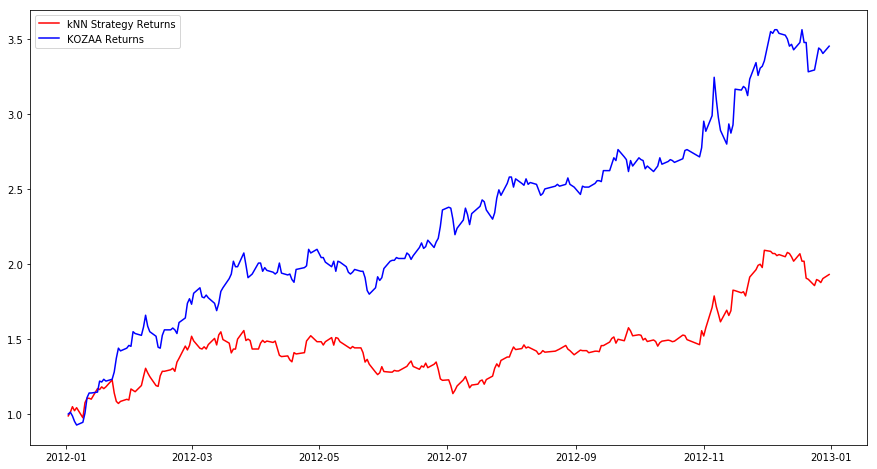

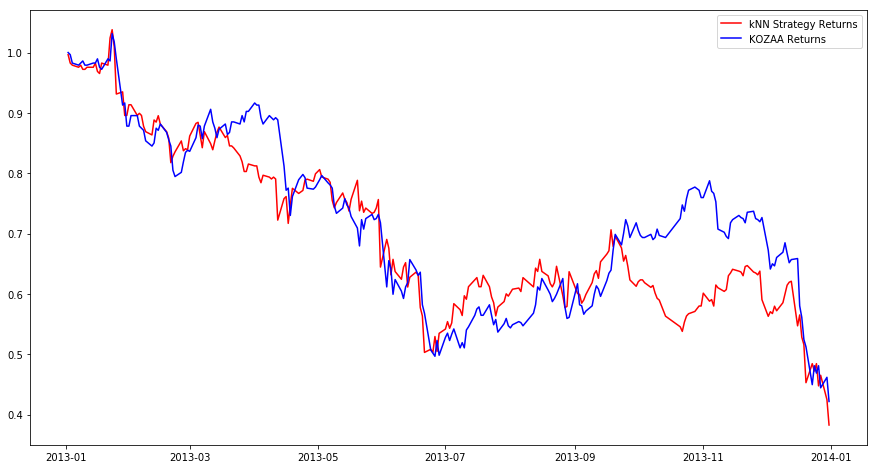

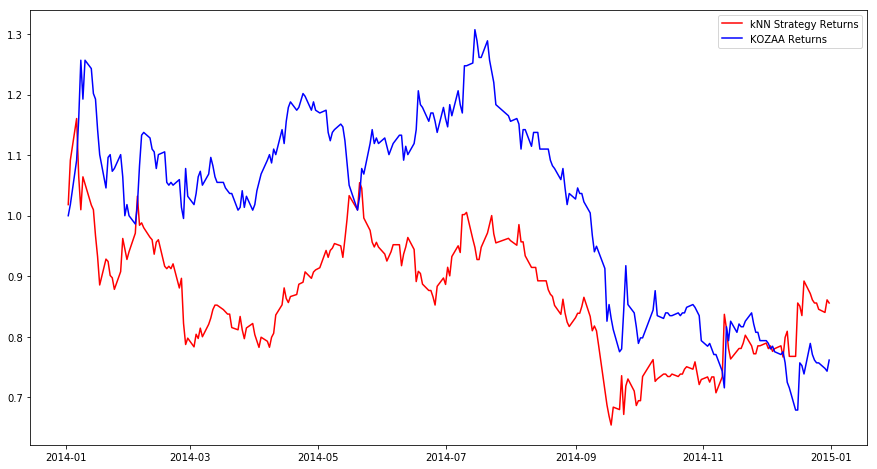

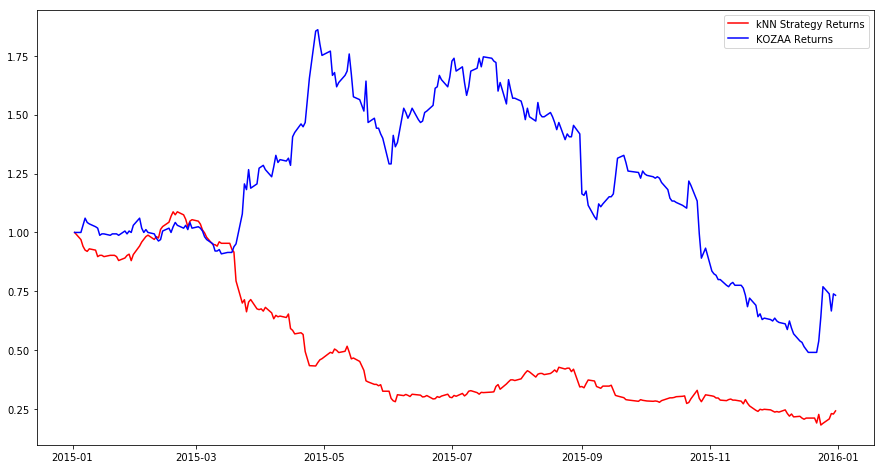

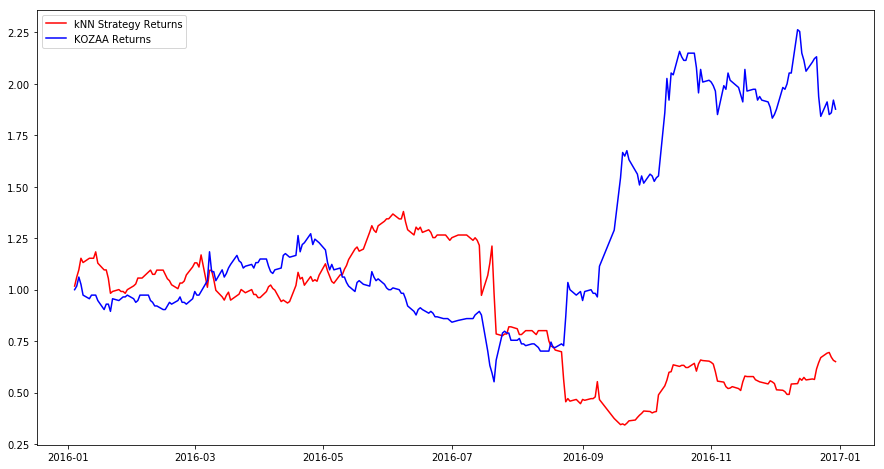

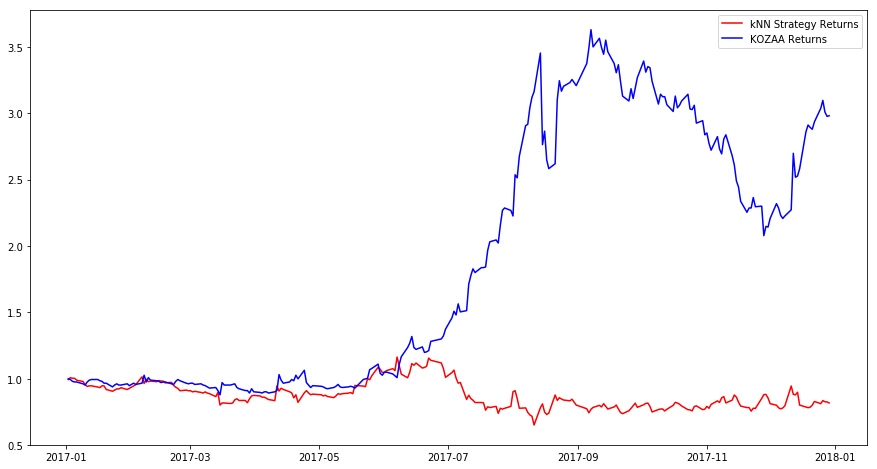

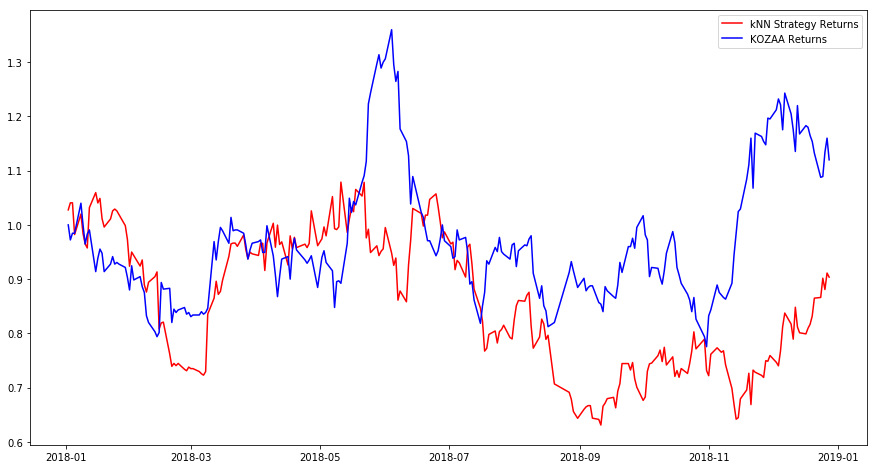

In [11]:
for i in range(2009,2016):
    plt.figure(figsize=(15,8))
    plt.plot(cumretsdic["cumrets{0}".format(i)], color ="r", label="kNN Strategy Returns")
    plt.plot(kozaa[kozaa.index.year==i+3]["Close"]/kozaa[kozaa.index.year==i+3]["Close"][0],color ="b", label="KOZAA Returns")
    plt.legend()
    plt.show()

In [12]:
portretsall = pd.DataFrame()
for i in range(2009,2016):
    portrets = ypred_dic["ypred{0}".format(i)]*kozaa[kozaa.index.year==i+3]["ForwardReturns"]
    portrets = pd.DataFrame(portrets, index = kozaa[kozaa.index.year==i+3].index)
    portretsall = pd.concat([portretsall,portrets])

In [13]:
cumretsall = np.cumprod(1+portretsall["ForwardReturns"])

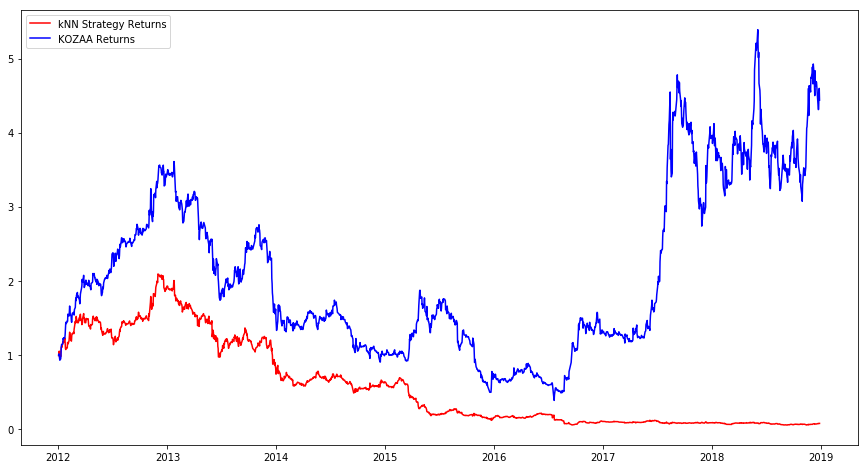

In [14]:
plt.figure(figsize=(15,8))
plt.plot(cumretsall, color ="r", label="kNN Strategy Returns")
plt.plot(kozaa.loc["2012-01-02":,"Close"]/kozaa.loc["2012-01-02":,"Close"][0],color ="b", label="KOZAA Returns")
plt.legend()
plt.show()

In [15]:
# Classifier accuracy
print("Classifier Accuracy(%):",round(metrics.accuracy_score(np.concatenate(list(ytestdic.values())), np.concatenate(list(ypred_dic.values())))*100,2))
# Classifier precision
print("Classifier Precision(%):",round(metrics.precision_score(np.concatenate(list(ytestdic.values())), np.concatenate(list(ypred_dic.values())))*100,2))
#Difference to buy-and-hold
print("Difference to buy-and-hold(%):",round((cumretsall[-1]/(kozaa.loc["2012-01-02":,"Close"]/kozaa.loc["2012-01-02":,"Close"][0])[-1]-1)*100,2))

Classifier Accuracy(%): 49.23
Classifier Precision(%): 49.9
Difference to buy-and-hold(%): -98.34


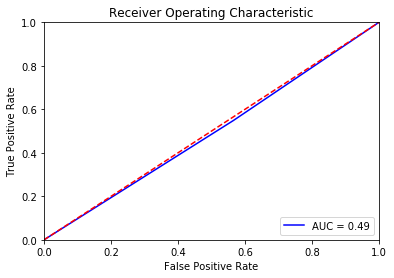

In [16]:
fpr, tpr, threshold = metrics.roc_curve(np.concatenate(list(ytestdic.values())), np.concatenate(list(ypred_dic.values())))
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
# Calculating error for K values between 1 and 50
meanerrors = []
allcumrets = []
for j in range(1, 51):
    error = []
    portretsall_j = pd.DataFrame()
    for i in range(2009,2016):
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(Xtraindic["X_train{0}".format(i)], ytraindic["y_train{0}".format(i)])
        pred_i = knn.predict(Xtestdic["X_test{0}".format(i)])
        error.append(np.mean(pred_i != ytestdic["y_test{0}".format(i)]))
        portrets_i = pred_i*kozaa[kozaa.index.year==i+3]["ForwardReturns"]
        portrets_i = pd.DataFrame(portrets_i, index = kozaa[kozaa.index.year==i+3].index)
        portretsall_j = pd.concat([portretsall_j,portrets_i])
    cumrets = (np.cumprod(1+portretsall_j["ForwardReturns"]))[-1]
    allcumrets.append(cumrets)
    meanerrors.append(np.mean(error))

Text(0, 0.5, 'Mean Error')

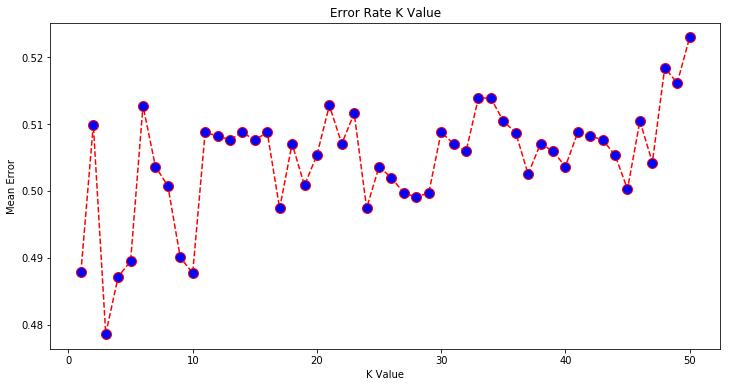

In [18]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 51), meanerrors, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

Text(0, 0.5, 'Difference to Buy-and-Hold (%)')

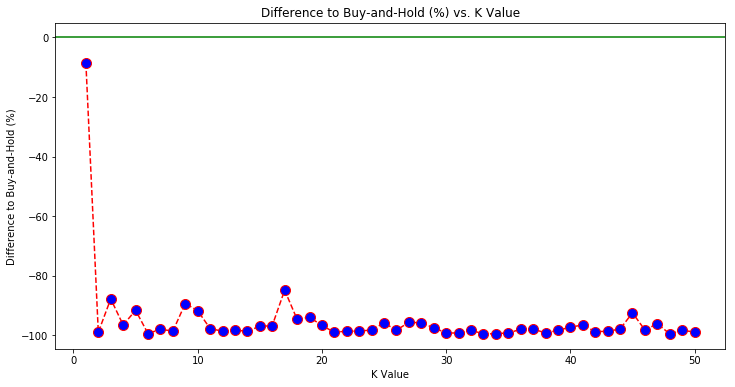

In [19]:
diffbh = (allcumrets/(kozaa.loc["2012-01-02":,"Close"]/kozaa.loc["2012-01-02":,"Close"][0])[-1]-1)*100
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 51), diffbh, color='red', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Difference to Buy-and-Hold (%) vs. K Value')  
plt.xlabel('K Value')
plt.ylabel('Difference to Buy-and-Hold (%)')  

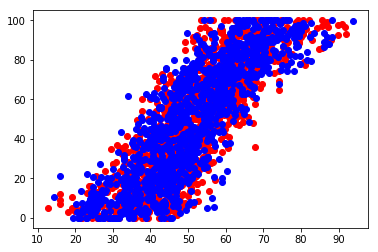

In [20]:
plt.plot(kozaa.loc[kozaa["ReturnSign"]==1,]["RSI"],kozaa.loc[kozaa["ReturnSign"]==1,]["%K"],"ro", label="Up")
plt.plot(kozaa.loc[kozaa["ReturnSign"]==-1,]["RSI"],kozaa.loc[kozaa["ReturnSign"]==-1,]["%K"],"bo", label="Down")

In [21]:
# Calculate Final Returns
print("Buy-and-hold return(%):", round(((kozaa.loc["2012-01-02":,"Close"]/kozaa.loc["2012-01-02":,"Close"][0])[-1]-1)*100,2))
print("kNN return(%):",round((cumretsall[-1]-1)*100,2))

Buy-and-hold return(%): 343.9
kNN return(%): -92.62


In [22]:
### Calculate Performance and Risk Metrics
import empyrical as ep

## Buy-and-Hold
print("KOZAA")
# CAGR
print("CAGR:",round(ep.annual_return(kozaa.loc["2012-01-02":,"Returns"]),2))
# Annual Volatility
print("Annual Volatility:",round(ep.annual_volatility(kozaa.loc["2012-01-02":,"Returns"]),2))
# Maximum Drawdown
print("Maximum Drawdown:",round(ep.max_drawdown(kozaa.loc["2012-01-02":,"Returns"]),2))
# Sharpe Ratio
print("Sharpe Ratio:",round(ep.sharpe_ratio(kozaa.loc["2012-01-02":,"Returns"]),2))
# Calmar Ratio
print("Calmar Ratio:",round(ep.calmar_ratio(kozaa.loc["2012-01-02":,"Returns"]),2))

## k-NN
print("k-NN")
# CAGR
print("CAGR:",round(ep.annual_return(portretsall["ForwardReturns"]),2))
# Annual Volatility
print("Annual Volatility:",round(ep.annual_volatility(portretsall["ForwardReturns"]),2))
# Maximum Drawdown
print("Maximum Drawdown:",round(ep.max_drawdown(portretsall["ForwardReturns"]),2))
# Sharpe Ratio
print("Sharpe Ratio:",round(ep.sharpe_ratio(portretsall["ForwardReturns"]),2))
# Calmar Ratio
print("Calmar Ratio:",round(ep.calmar_ratio(portretsall["ForwardReturns"]),2))

KOZAA
CAGR: 0.24
Annual Volatility: 0.59
Maximum Drawdown: -0.89
Sharpe Ratio: 0.65
Calmar Ratio: 0.26
k-NN
CAGR: -0.31
Annual Volatility: 0.59
Maximum Drawdown: -0.98
Sharpe Ratio: -0.34
Calmar Ratio: -0.32


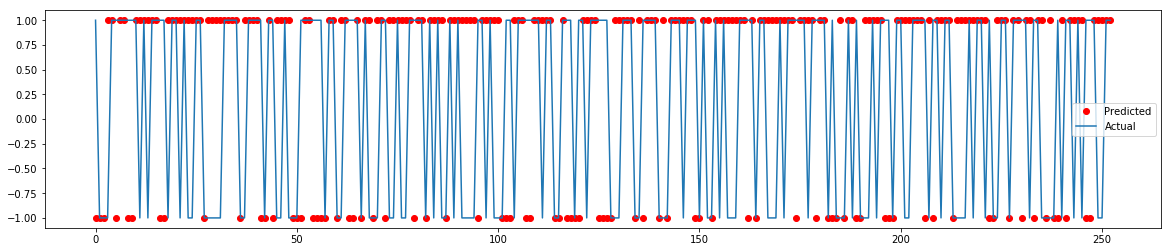

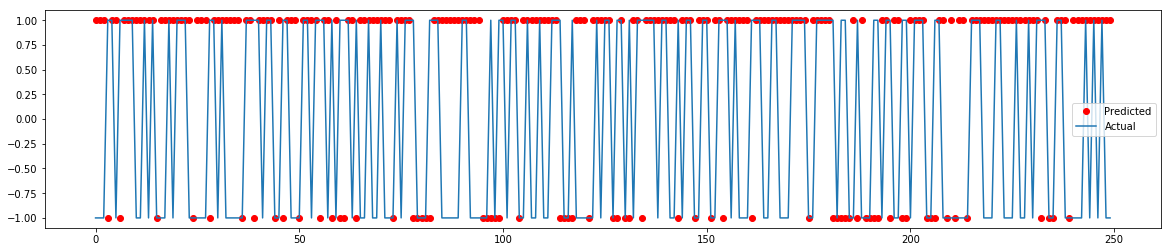

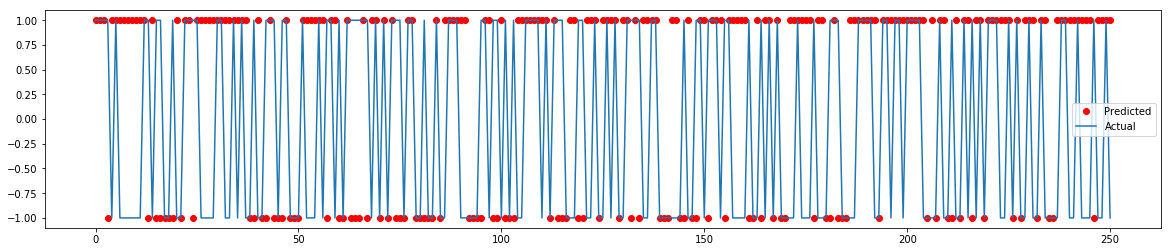

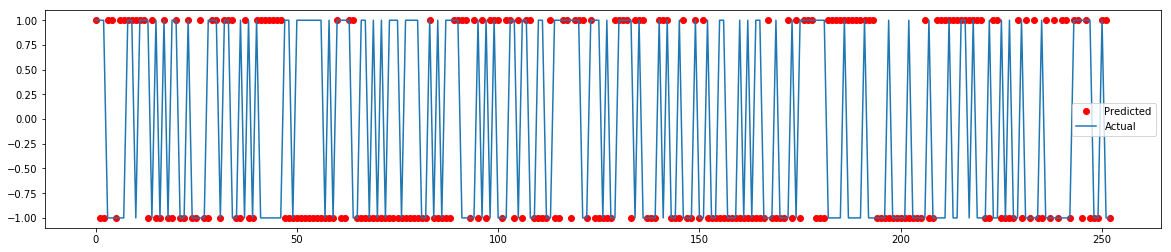

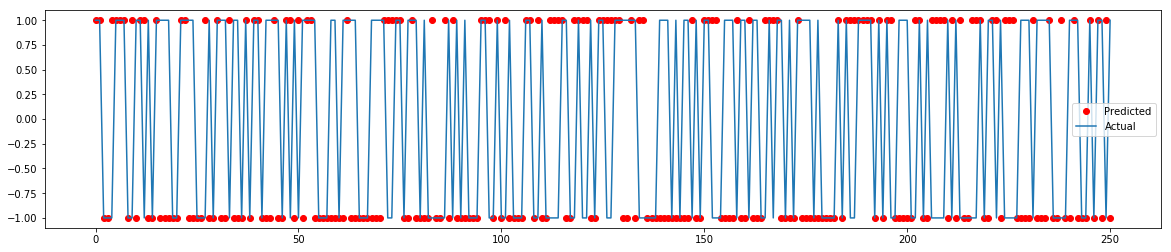

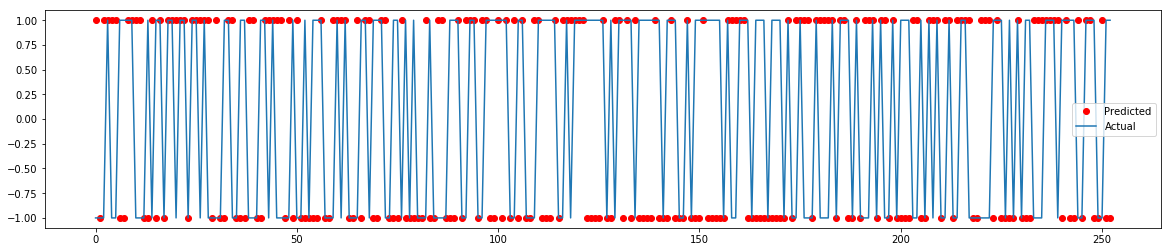

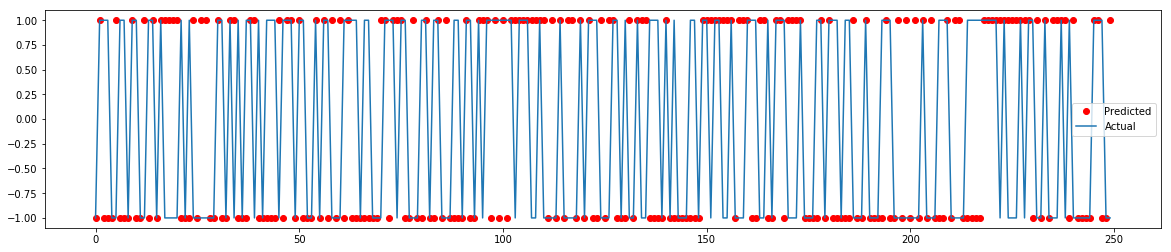

In [23]:
#Actual vs Predicted Graphs
for i in range(2009,2016):
    plt.figure(figsize=(20,4))  
    plt.plot(ypred_dic["ypred{0}".format(i)],"ro", label = "Predicted")
    plt.plot(ytestdic["y_test{0}".format(i)],label= "Actual")
    plt.legend()